In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.append(os.path.abspath('..'))
from src.utils.seed import set_seed
from src.utils.config import Config
from src.preprocessing import get_data_loaders
from src.models import MLP
from src.evaluation import calculate_metrics

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

c:\Users\surya\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
config = Config('../configs/config.yaml')
train_loader, val_loader, test_loader, input_dim = get_data_loaders(config)

print(f"Input Features: {input_dim}")
print(f"Train Samples: {len(train_loader.dataset)}")
print(f"Val Samples: {len(val_loader.dataset)}")
print(f"Test Samples: {len(test_loader.dataset)}")

Input Features: 7
Train Samples: 130812
Val Samples: 18688
Test Samples: 37376


In [3]:
model = MLP(
    input_dim=input_dim,
    hidden_layers=config.model['mlp']['hidden_layers'],
    dropout=config.model['mlp']['dropout']
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=config.training['learning_rate'])

print(f"Model Architecture:")
print(model)
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture:
MLP(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total Parameters: 2,817


In [4]:
epochs = config.training['epochs']
patience = config.training.get('early_stopping_patience', 5)

train_losses = []
val_losses = []
val_aucs = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for X_batch, y_batch in progress_bar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / len(train_loader)
    
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float().unsqueeze(1)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_metrics = calculate_metrics(np.array(all_labels), np.array(all_probs))
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_aucs.append(val_metrics['auc'])
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val AUC: {val_metrics['auc']:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../reports/results/checkpoints/mlp_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print("\n✓ Training Complete!")

Epoch 1/50: 100%|██████████| 4088/4088 [00:23<00:00, 177.05it/s, loss=0.0212]


Epoch 1/50 - Train Loss: 0.0691, Val Loss: 0.0327, Val AUC: 0.9993


Epoch 2/50: 100%|██████████| 4088/4088 [00:20<00:00, 196.81it/s, loss=0.1281]


Epoch 2/50 - Train Loss: 0.0487, Val Loss: 0.0314, Val AUC: 0.9993


Epoch 3/50: 100%|██████████| 4088/4088 [00:20<00:00, 197.38it/s, loss=0.0890]


Epoch 3/50 - Train Loss: 0.0444, Val Loss: 0.0330, Val AUC: 0.9993


Epoch 4/50: 100%|██████████| 4088/4088 [00:25<00:00, 161.56it/s, loss=0.0332]


Epoch 4/50 - Train Loss: 0.0432, Val Loss: 0.0320, Val AUC: 0.9993


Epoch 5/50: 100%|██████████| 4088/4088 [00:21<00:00, 193.47it/s, loss=0.0939]


Epoch 5/50 - Train Loss: 0.0418, Val Loss: 0.0312, Val AUC: 0.9993


Epoch 6/50: 100%|██████████| 4088/4088 [00:20<00:00, 202.71it/s, loss=0.0135]


Epoch 6/50 - Train Loss: 0.0416, Val Loss: 0.0309, Val AUC: 0.9994


Epoch 7/50: 100%|██████████| 4088/4088 [00:23<00:00, 172.98it/s, loss=0.0213]


Epoch 7/50 - Train Loss: 0.0417, Val Loss: 0.0310, Val AUC: 0.9994


Epoch 8/50: 100%|██████████| 4088/4088 [00:21<00:00, 194.35it/s, loss=0.0922]


Epoch 8/50 - Train Loss: 0.0407, Val Loss: 0.0308, Val AUC: 0.9994


Epoch 9/50: 100%|██████████| 4088/4088 [00:20<00:00, 198.03it/s, loss=0.0491]


Epoch 9/50 - Train Loss: 0.0406, Val Loss: 0.0358, Val AUC: 0.9994


Epoch 10/50: 100%|██████████| 4088/4088 [00:21<00:00, 191.05it/s, loss=0.0130]


Epoch 10/50 - Train Loss: 0.0405, Val Loss: 0.0305, Val AUC: 0.9994


Epoch 11/50: 100%|██████████| 4088/4088 [00:20<00:00, 198.01it/s, loss=0.0038]


Epoch 11/50 - Train Loss: 0.0407, Val Loss: 0.0321, Val AUC: 0.9994


Epoch 12/50: 100%|██████████| 4088/4088 [00:20<00:00, 196.29it/s, loss=0.0253]


Epoch 12/50 - Train Loss: 0.0404, Val Loss: 0.0320, Val AUC: 0.9994


Epoch 13/50: 100%|██████████| 4088/4088 [00:21<00:00, 193.02it/s, loss=0.1159]


Epoch 13/50 - Train Loss: 0.0401, Val Loss: 0.0318, Val AUC: 0.9993


Epoch 14/50: 100%|██████████| 4088/4088 [00:20<00:00, 195.41it/s, loss=0.0469]


Epoch 14/50 - Train Loss: 0.0402, Val Loss: 0.0313, Val AUC: 0.9993


Epoch 15/50: 100%|██████████| 4088/4088 [00:21<00:00, 192.49it/s, loss=0.0105]


Epoch 15/50 - Train Loss: 0.0396, Val Loss: 0.0322, Val AUC: 0.9994
Early stopping at epoch 15

✓ Training Complete!


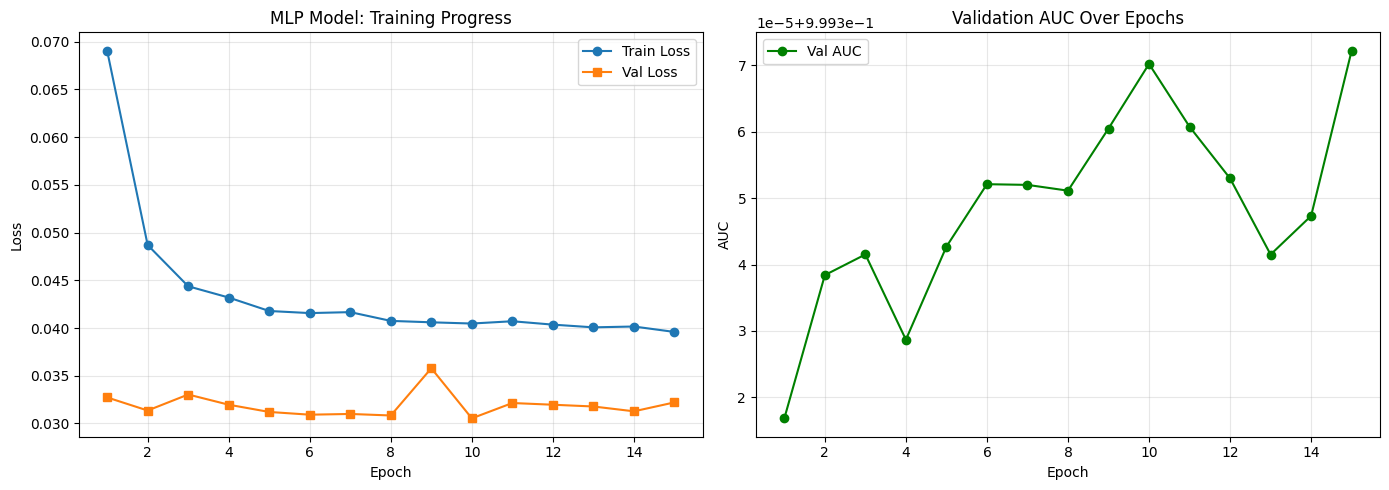

In [5]:
epochs_trained = len(train_losses)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, epochs_trained+1), train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, epochs_trained+1), val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('MLP Model: Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, epochs_trained+1), val_aucs, label='Val AUC', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Validation AUC Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
model.load_state_dict(torch.load('../reports/results/checkpoints/mlp_best.pth'))
model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs).cpu().numpy()
        
        all_probs.extend(probs.flatten())
        all_labels.extend(y_batch.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

test_metrics = calculate_metrics(all_labels, all_probs)

print("MLP Model Test Results (Best Checkpoint):")
for metric, value in test_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

MLP Model Test Results (Best Checkpoint):
  ACCURACY: 0.9892
  PRECISION: 0.9886
  RECALL: 0.9879
  F1: 0.9882
  AUC: 0.9993


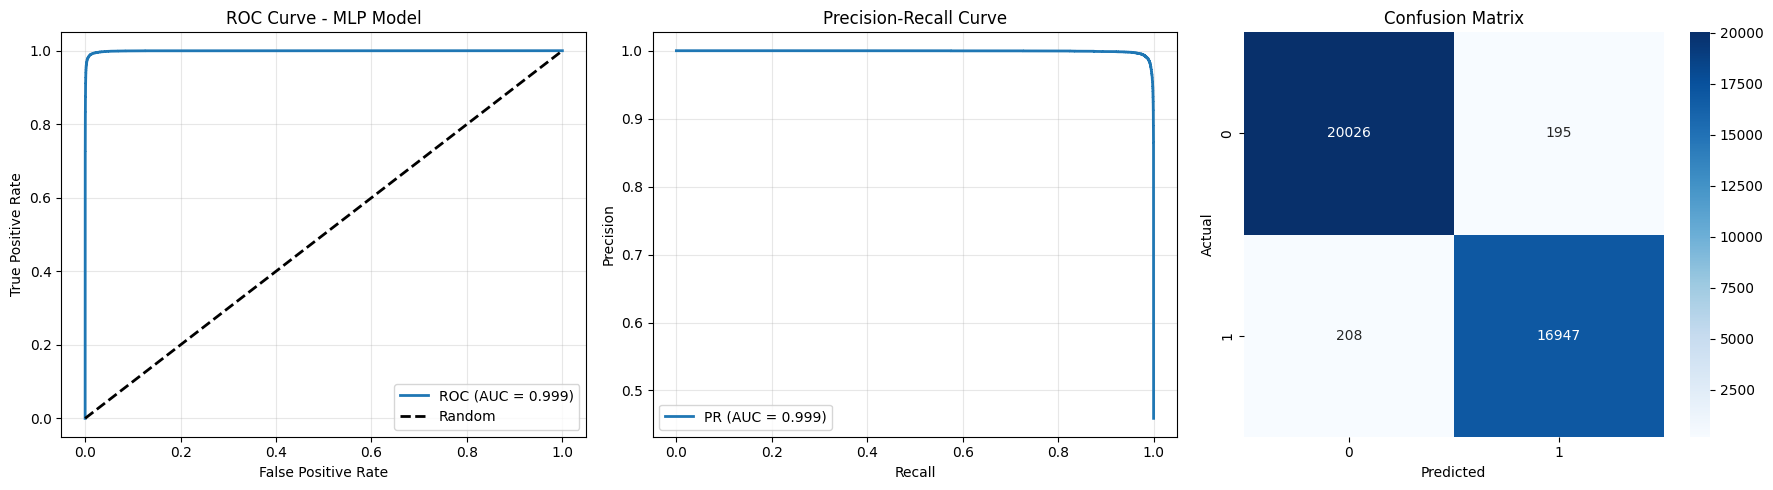

In [7]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, auc
import seaborn as sns

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - MLP Model')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(recall, precision, lw=2, label=f'PR (AUC = {pr_auc:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

cm = confusion_matrix(all_labels, (all_probs > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

In [8]:
print("✓ MLP training complete!")
print(f"Best model saved at: reports/results/checkpoints/mlp_best.pth")

✓ MLP training complete!
Best model saved at: reports/results/checkpoints/mlp_best.pth
